# Options Part 4 - Supervisory Delta Adjustments


## Introduction to Supervisory Delta Adjustments
Supervisory Delta adjustments are part of a regulatory framework aimed at managing risk in financial derivatives. These adjustments are specified under **12 CFR Part 217**, which governs regulatory capital requirements for banks and financial institutions. In particular, Supervisory Delta is relevant in the context of **SA-CCR** (Standardized Approach for Counterparty Credit Risk), a framework for calculating capital requirements for counterparty credit risk.

### Purpose of Supervisory Delta
While Classical Delta measures the sensitivity of an option’s price to changes in the underlying asset’s price, Supervisory Delta adjusts this concept to reflect regulatory requirements. It provides a standardized measure for regulatory capital calculations, ensuring consistency and prudence in risk management practices.

### Key Types of Supervisory Delta Adjustments
1. **Options Contracts (Bought and Sold)**: Calculated based on a modified version of the Black-Scholes model, including the adjustment factor $\lambda$ for specific interest rate options.
2. **Non-Option Derivatives (Swaps)**: Delta is fixed at 1 (or -1), reflecting linear price sensitivity for straightforward instruments.
3. **CDO Tranches**: A specific formula considers the attachment and detachment points to calculate Delta.

This notebook will cover each type of Supervisory Delta adjustment in detail, explaining the calculation methods and the rationale behind them.



## Supervisory Delta Adjustment for Options Contracts
For options, the Supervisory Delta is based on a modified version of the Black-Scholes formula, incorporating an additional adjustment factor, $\lambda$, related to regulatory requirements.

### Supervisory Delta Formula for Options
The Supervisory Delta for options is calculated as:
$$ \Delta = \Phi \left( \frac{\ln \left( \frac{P + \lambda}{K + \lambda} \right) + 0.5 \cdot \sigma^2 \cdot \frac{T}{250}}{\sigma \cdot \sqrt{\frac{T}{250}}} \right) $$

where:
- $\Phi$: Standard normal cumulative distribution function
- $P$: Current fair value of the underlying asset or risk factor
- $K$: Strike price of the option
- $T$: Number of business days until expiration
- $\lambda$: Adjustment factor for regulatory currency risk, relevant in certain cases for interest rate options with negative rates
- $\sigma$: Supervisory option volatility

### Understanding the Adjustment Factor ($\lambda$)
In the context of certain interest rate options, the adjustment factor $\lambda$ is introduced to handle cases where the option is affected by a negative interest rate environment. The formula for $\lambda$ is:
$$ \lambda = \max\{-L + 0.1\%, 0\} $$
where \( L \) is the minimum between $P$ and $K$ (the option's current fair price and strike price).

This adjustment factor helps ensure that the Supervisory Delta measure remains prudent and accurately reflects the option’s behavior under negative interest rates. By modifying $P$ and $K$ by $\lambda$, the calculation stabilizes Delta sensitivity, especially under adverse rate conditions. 


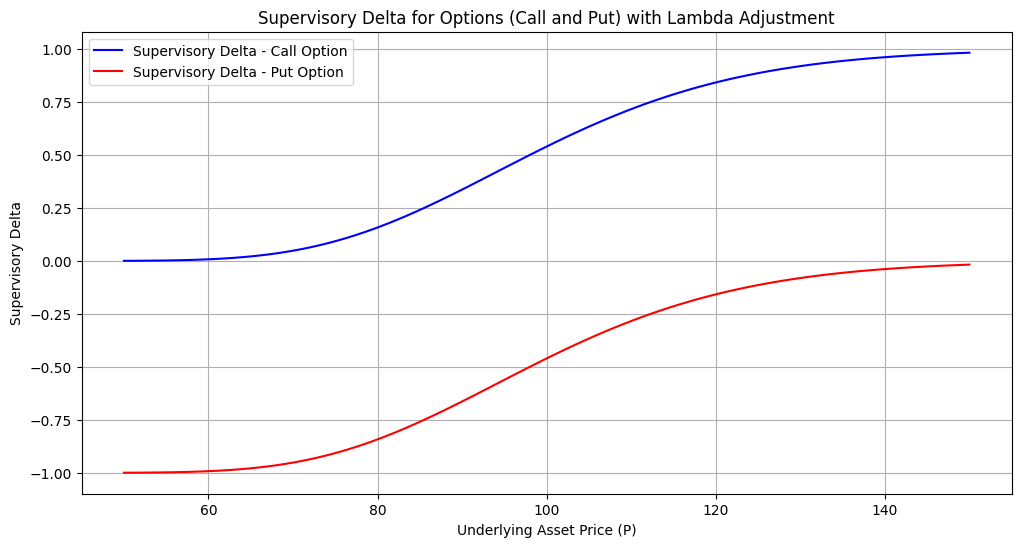

In [1]:

# Import necessary libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define Supervisory Delta for Options with Lambda
def supervisory_delta_option(P, K, T, sigma, lambda_val, option_type="call"):
    # Calculate d1 with regulatory adjustments
    d1 = (np.log((P + lambda_val) / (K + lambda_val)) + 0.5 * sigma ** 2 * (T / 250)) / (sigma * np.sqrt(T / 250))
    if option_type == "call":
        return norm.cdf(d1)
    elif option_type == "put":
        return norm.cdf(d1) - 1

# Parameters for visualization
K = 100  # Strike price
T = 250  # Number of business days to expiration (approximately 1 year)
sigma = 0.2  # Supervisory option volatility
lambda_val = 1.0  # Regulatory adjustment factor

# Range of underlying asset prices
P_range = np.linspace(50, 150, 100)

# Calculate Supervisory Delta for call and put options
supervisory_delta_call = [supervisory_delta_option(P, K, T, sigma, lambda_val, "call") for P in P_range]
supervisory_delta_put = [supervisory_delta_option(P, K, T, sigma, lambda_val, "put") for P in P_range]

# Plotting Supervisory Delta for Call and Put Options
plt.figure(figsize=(12, 6))
plt.plot(P_range, supervisory_delta_call, label="Supervisory Delta - Call Option", color="blue")
plt.plot(P_range, supervisory_delta_put, label="Supervisory Delta - Put Option", color="red")
plt.xlabel("Underlying Asset Price (P)")
plt.ylabel("Supervisory Delta")
plt.title("Supervisory Delta for Options (Call and Put) with Lambda Adjustment")
plt.legend()
plt.grid(True)
plt.show()



## Supervisory Delta Adjustment for Non-Option Derivatives (Swaps)
Swaps, unlike options, have a **linear payoff** structure. This means that their value changes directly with the price of the underlying reference rate or asset, without the complex sensitivity characteristics (e.g., Gamma) that options have.

### Why Swaps Have a Fixed Delta
In regulatory calculations, swaps are treated as having a fixed Supervisory Delta of:
- **+1** for long positions, where an increase in the reference rate increases the swap's value.
- **-1** for short positions, where an increase in the reference rate decreases the swap's value.

This simple, linear relationship allows swaps to be treated consistently across different regulatory calculations. Because they lack optionality, they do not require the probability adjustments and additional terms used in options.

### Visualizing Supervisory Delta for Swaps
Below is a visualization of the constant Delta for both long and short swap positions, showing how the Supervisory Delta remains fixed regardless of the underlying asset or reference rate.


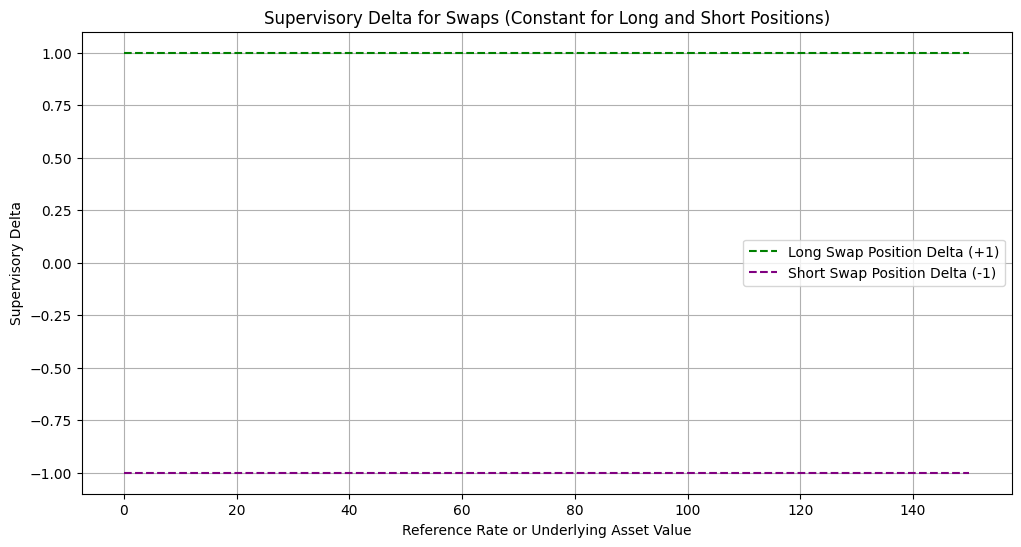

In [2]:

# Define constants for swap Supervisory Delta
swap_delta_long = 1.0
swap_delta_short = -1.0
reference_rates = np.linspace(0, 150, 100)

# Plotting Supervisory Delta for Swaps with constant Delta lines
plt.figure(figsize=(12, 6))
plt.plot(reference_rates, [swap_delta_long]*len(reference_rates), label="Long Swap Position Delta (+1)", color="green", linestyle="--")
plt.plot(reference_rates, [swap_delta_short]*len(reference_rates), label="Short Swap Position Delta (-1)", color="purple", linestyle="--")
plt.xlabel("Reference Rate or Underlying Asset Value")
plt.ylabel("Supervisory Delta")
plt.title("Supervisory Delta for Swaps (Constant for Long and Short Positions)")
plt.legend()
plt.grid(True)
plt.show()



## Supervisory Delta Adjustment for CDO Tranches
**Collateralized Debt Obligations (CDOs)** are structured financial products that pool together various assets, often loans or bonds. These assets are then divided into tranches based on risk, providing investors with varying levels of exposure.

### What are Tranches in a CDO?
- **Senior Tranche**: The safest part of the CDO, repaid first and exposed to the least risk. It has a low attachment point and a high detachment point.
- **Equity Tranche**: The riskiest tranche, last to be repaid. It has a high attachment point and a low detachment point.

### The Attachment and Detachment Points
- **Attachment Point (A)**: Represents the portion of losses that a tranche will start absorbing. It indicates the level below which the tranche has no exposure to losses.
- **Detachment Point (D)**: Represents the portion of losses at which the tranche is completely wiped out. It indicates the level above which the tranche has no remaining exposure.

### Supervisory Delta Formula for CDO Tranches
The Supervisory Delta for CDO tranches adjusts for these unique risk levels:
$$ \text{Supervisory Delta Adjustment} = \frac{15}{(1 + 14 \cdot A) \cdot (1 + 14 \cdot D)} $$

This formula reflects:
1. **Risk Exposure of Each Tranche**: Tranches with lower attachment and detachment points have higher risk and thus a lower Supervisory Delta.
2. **Conservative Capital Requirements**: The formula ensures that higher-risk tranches contribute more conservatively to capital requirements, aligning with regulatory goals.

The Supervisory Delta adjustment for CDO tranches helps capture the layered risk within the CDO structure, aligning the capital requirements with the actual risk exposure in each tranche.

### Visualizing Supervisory Delta for CDO Tranches
The plot below illustrates how Supervisory Delta varies as the attachment ($A$) and detachment points ($D$) change. This visualization reflects how the Supervisory Delta is sensitive to the tranche's risk level, as defined by its attachment and detachment points.


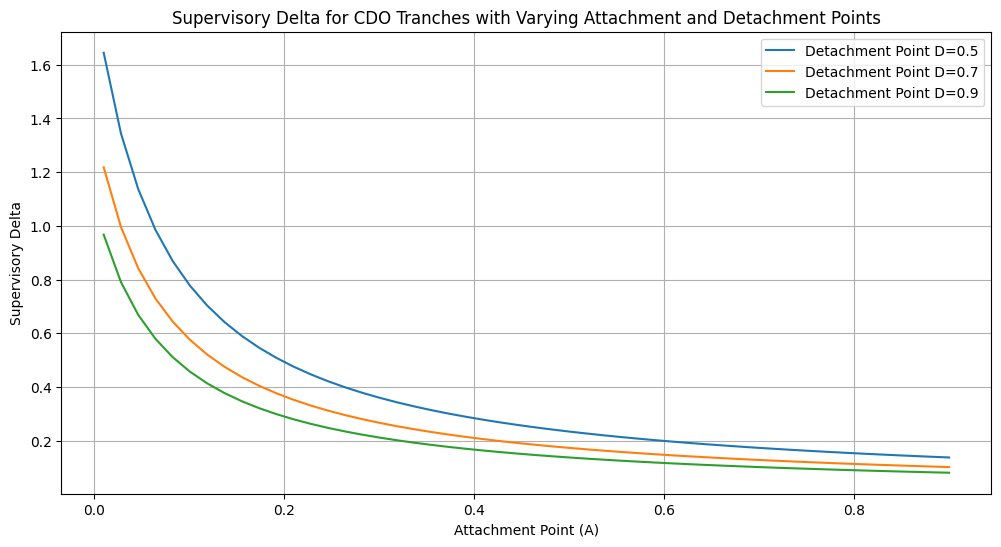

In [3]:

# Define Supervisory Delta for CDO Tranches
def supervisory_delta_cdo(A, D):
    return 15 / ((1 + 14 * A) * (1 + 14 * D))

# Varying attachment and detachment points
attachment_points = np.linspace(0.01, 0.9, 50)
detachment_points = [0.5, 0.7, 0.9]  # Different detachment levels

# Plotting Supervisory Delta for different detachment points
plt.figure(figsize=(12, 6))
for D in detachment_points:
    supervisory_deltas = [supervisory_delta_cdo(A, D) for A in attachment_points]
    plt.plot(attachment_points, supervisory_deltas, label=f"Detachment Point D={D}")

plt.xlabel("Attachment Point (A)")
plt.ylabel("Supervisory Delta")
plt.title("Supervisory Delta for CDO Tranches with Varying Attachment and Detachment Points")
plt.legend()
plt.grid(True)
plt.show()



## Delta's Role in Adjusted Derivative Contract Amounts and RWA
In the context of regulatory capital calculations, **Supervisory Delta** serves as an input to determine the adjusted derivative contract amount, which is then factored into **Risk-Weighted Assets (RWA)**. This flow enables the standardized approach under SA-CCR to measure counterparty credit risk accurately.

### Why Delta is Used in Adjusted Contract Amounts
The Supervisory Delta of each derivative type modifies its **notional amount** to reflect the actual exposure of the contract. This adjusted value aligns the regulatory calculation with the sensitivity and risk profile of each position. By using Delta in this way, capital requirements can better capture the risk exposure of both linear and non-linear derivatives, ensuring that RWA calculations are sensitive to market movements.

Each Delta type feeds into the adjusted derivative contract amount as follows:
1. **Options**: Delta adjusts the notional value based on the sensitivity of the option to the underlying price, incorporating regulatory adjustments like $\lambda$ for interest rate options.
2. **Swaps**: Fixed Delta values of +1 or -1 directly scale the exposure, as swaps have linear, predictable payoffs.
3. **CDO Tranches**: Delta accounts for tranche-specific risk, adjusting based on attachment and detachment points to reflect the layered credit risk.

This process is fundamental to calculating RWA, providing a risk-weighted measure that aligns capital reserves with exposure levels across derivative types.
